
<h1 style="font-size:2rem; color:red;"> Music Genre Prediction </h1>

## Importing the libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import sklearn.metrics as skm
import sklearn.model_selection as skms
import sklearn.preprocessing as skp 

import random
import librosa
import IPython
import librosa.display as lplt
import os


seed = 12
np.random.seed(seed)






## loading Dataset

In [2]:
df = pd.read_csv(r"D:\Jupyter Notebook Files\Music Genre Prediction model\Data\features_3_sec.csv")
df.head()

filename  length  chroma_stft_mean  chroma_stft_var  rms_mean  \
0  blues.00000.0.wav   66149          0.335406         0.091048  0.130405   
1  blues.00000.1.wav   66149          0.343065         0.086147  0.112699   
2  blues.00000.2.wav   66149          0.346815         0.092243  0.132003   
3  blues.00000.3.wav   66149          0.363639         0.086856  0.132565   
4  blues.00000.4.wav   66149          0.335579         0.088129  0.143289   

    rms_var  spectral_centroid_mean  spectral_centroid_var  \
0  0.003521             1773.065032          167541.630869   
1  0.001450             1816.693777           90525.690866   
2  0.004620             1788.539719          111407.437613   
3  0.002448             1655.289045          111952.284517   
4  0.001701             1630.656199           79667.267654   

   spectral_bandwidth_mean  spectral_bandwidth_var  ...  mfcc16_var  \
0              1972.744388           117335.771563  ...   39.687145   
1              2010.051501            65671.875673  ...   64.748276   
2              2084.565132            75124.921716  ...   67.336563   
3              1960.039988            82913.639269  ...   47.739452   
4              1948.503884            60204.020268  ...   30.336359   

   mfcc17_mean  mfcc17_var  mfcc18_mean  mfcc18_var  mfcc19_mean  mfcc19_var  \
0    -3.241280   36.488243     0.722209   38.099152    -5.050335   33.618073   
1    -6.055294   40.677654     0.159015   51.264091    -2.837699   97.030830   
2    -1.768610   28.348579     2.378768   45.717648    -1.938424   53.050835   
3    -3.841155   28.337118     1.218588   34.770935    -3.580352   50.836224   
4     0.664582   45.880913     1.689446   51.363583    -3.392489   26.738789   

   mfcc20_mean  mfcc20_var  label  
0    -0.243027   43.771767  blues  
1     5.784063   59.943081  blues  
2     2.517375   33.105122  blues  
3     3.630866   32.023678  blues  
4     0.536961   29.146694  blues  

[5 rows x 60 columns]

In [3]:
print("Dataset has", df.shape)
print("Count of Positive samples")
df.label.value_counts().reset_index()


Dataset has (9990, 60)
Count of Positive samples


label  count
0      blues   1000
1       jazz   1000
2        pop   1000
3     reggae   1000
4      metal   1000
5      disco    999
6  classical    998
7     hiphop    998
8       rock    998
9    country    997

## Data Visualisation for a single audio

In [5]:
audio_file_path = r"D:\Jupyter Notebook Files\Music Genre Prediction model\Data\genres_original\rock\rock.00006.wav"
audio_data_array, sampling_rate = librosa.load(audio_file_path)
audio_data_array, _ = librosa.effects.trim(audio_data_array)

IPython.display.Audio(audio_data_array, rate=sampling_rate)

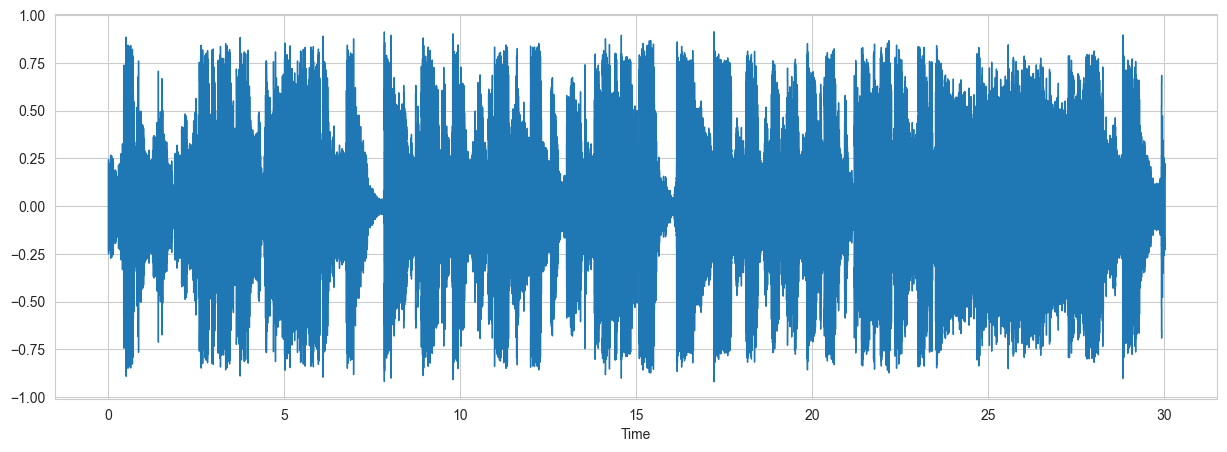

In [6]:
#Plotting the audio wave
plt.figure(figsize=(15,5))
lplt.waveshow(audio_data_array)
plt.show()

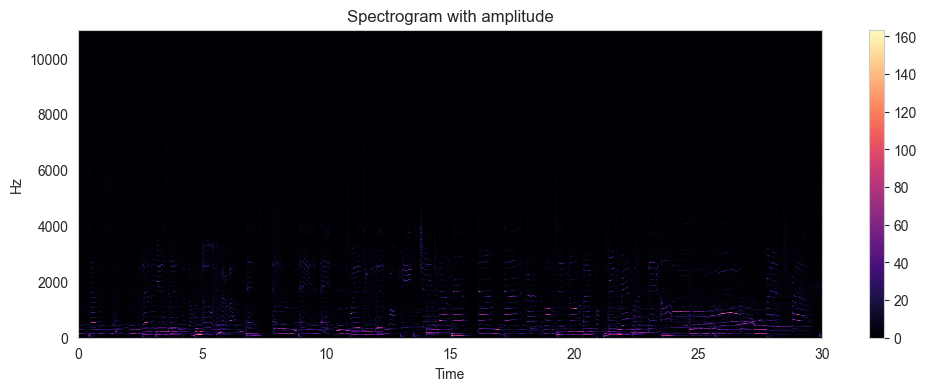

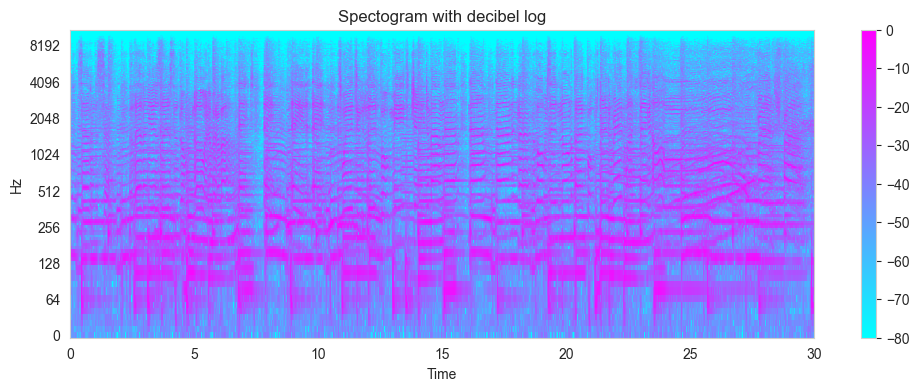

In [7]:
n = 2048 #window size
hop_length = 512 #The number of samples the window moves forward for

#Computing the short time fourier transform
stft = librosa.stft(audio_data_array, n_fft=n, hop_length=hop_length)
stft_to_decibel = librosa.amplitude_to_db(stft, ref=np.max)

#Spectogram with amplitude
plt.figure(figsize=(12,4))
lplt.specshow(stft, sr=sampling_rate, x_axis='time',y_axis='hz')
plt.colorbar()
plt.title("Spectrogram with amplitude")
plt.show()

#Spectogram with decibel scale
plt.figure(figsize=(12,4))
lplt.specshow(stft_to_decibel, sr=sampling_rate, x_axis="time", y_axis="log", cmap='cool')
plt.colorbar()
plt.title("Spectogram with decibel log")
plt.show()


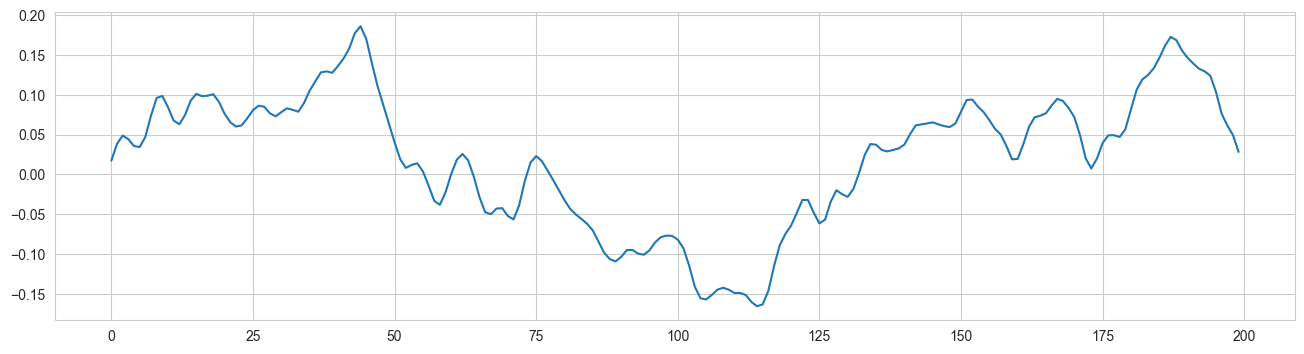

In [8]:
# plot a zoomed audio wave
start = 1000
end = 1200
# Hence we take only 200 samples from the array
plt.figure(figsize=(16,4))
plt.plot(audio_data_array[start:end])
plt.show()

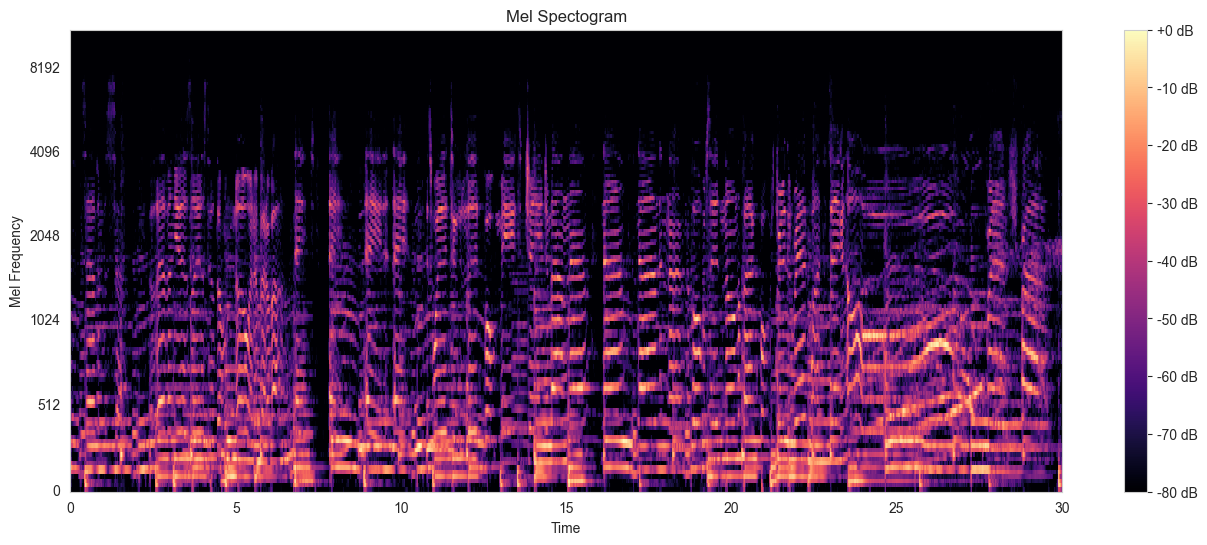

In [9]:
# Spectrogram using mel frequency
mel_spec = librosa.feature.melspectrogram(y=audio_data_array, sr=sampling_rate)
mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max)

plt.figure(figsize=(16,6))
librosa.display.specshow(mel_spec_db, sr= sampling_rate, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title("Mel Spectogram")
plt.xlabel("Time")
plt.ylabel("Mel Frequency")
plt.show()


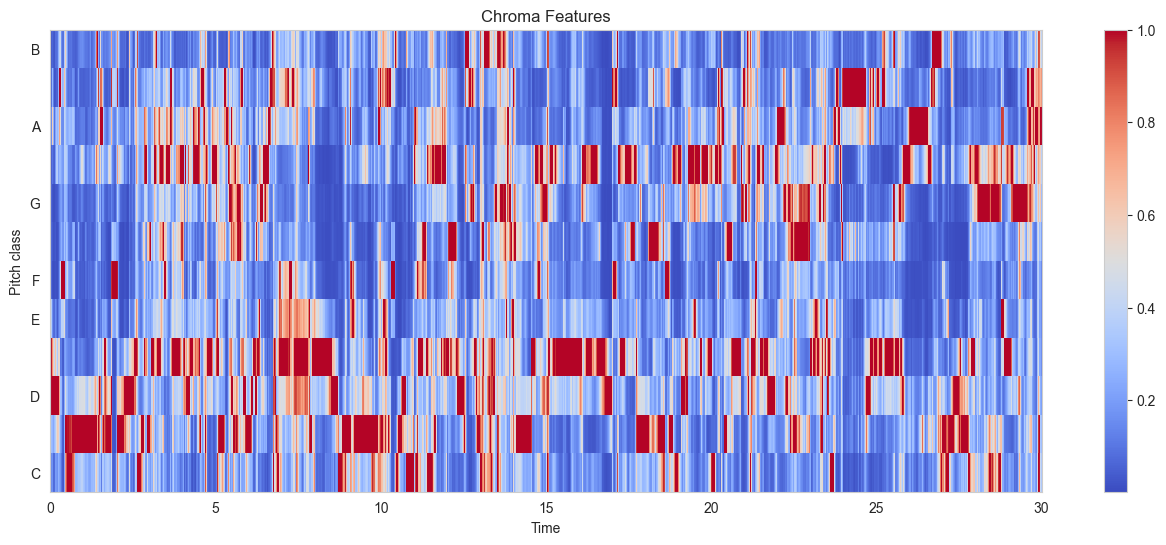

In [10]:
# Chroma feature
chroma = librosa.feature.chroma_stft(y=audio_data_array, sr=sampling_rate)
plt.figure(figsize=(16,6))
lplt.specshow(chroma, sr=sampling_rate, x_axis='time', y_axis='chroma', cmap='coolwarm')
plt.colorbar()
plt.title("Chroma Features")
plt.show()

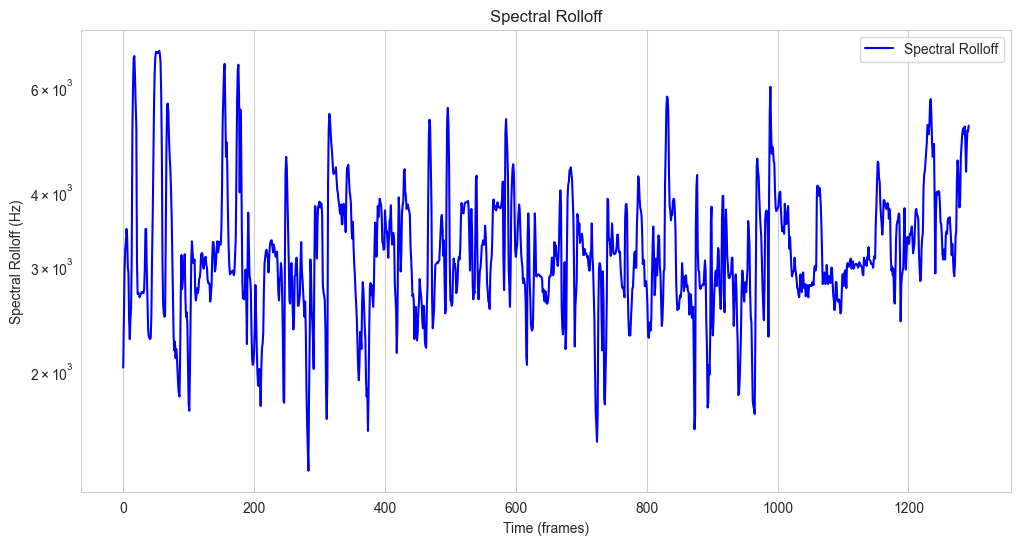

In [11]:
#Spectral Rolloff

spectral_rolloff = librosa.feature.spectral_rolloff(y=audio_data_array+0.01, sr= sampling_rate)[0]
plt.figure(figsize=(12, 6))
plt.semilogy(spectral_rolloff, label='Spectral Rolloff', color='b') 
plt.ylabel('Spectral Rolloff (Hz)')
plt.xlabel('Time (frames)')
plt.title('Spectral Rolloff')
plt.legend(loc='best')
plt.show()

## Correlation Matrix

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
        22.5, 23.5, 24.5, 25.5, 26.5, 27.5]),
 [Text(0, 0.5, 'chroma_stft_mean'),
  Text(0, 1.5, 'rms_mean'),
  Text(0, 2.5, 'spectral_centroid_mean'),
  Text(0, 3.5, 'spectral_bandwidth_mean'),
  Text(0, 4.5, 'rolloff_mean'),
  Text(0, 5.5, 'zero_crossing_rate_mean'),
  Text(0, 6.5, 'harmony_mean'),
  Text(0, 7.5, 'perceptr_mean'),
  Text(0, 8.5, 'mfcc1_mean'),
  Text(0, 9.5, 'mfcc2_mean'),
  Text(0, 10.5, 'mfcc3_mean'),
  Text(0, 11.5, 'mfcc4_mean'),
  Text(0, 12.5, 'mfcc5_mean'),
  Text(0, 13.5, 'mfcc6_mean'),
  Text(0, 14.5, 'mfcc7_mean'),
  Text(0, 15.5, 'mfcc8_mean'),
  Text(0, 16.5, 'mfcc9_mean'),
  Text(0, 17.5, 'mfcc10_mean'),
  Text(0, 18.5, 'mfcc11_mean'),
  Text(0, 19.5, 'mfcc12_mean'),
  Text(0, 20.5, 'mfcc13_mean'),
  Text(0, 21.5, 'mfcc14_mean'),
  Text(0, 22.5, 'mfcc15_mean'),
  Text(0, 23.5, 'mfcc16_mean'),
  Text(0, 24.5, 

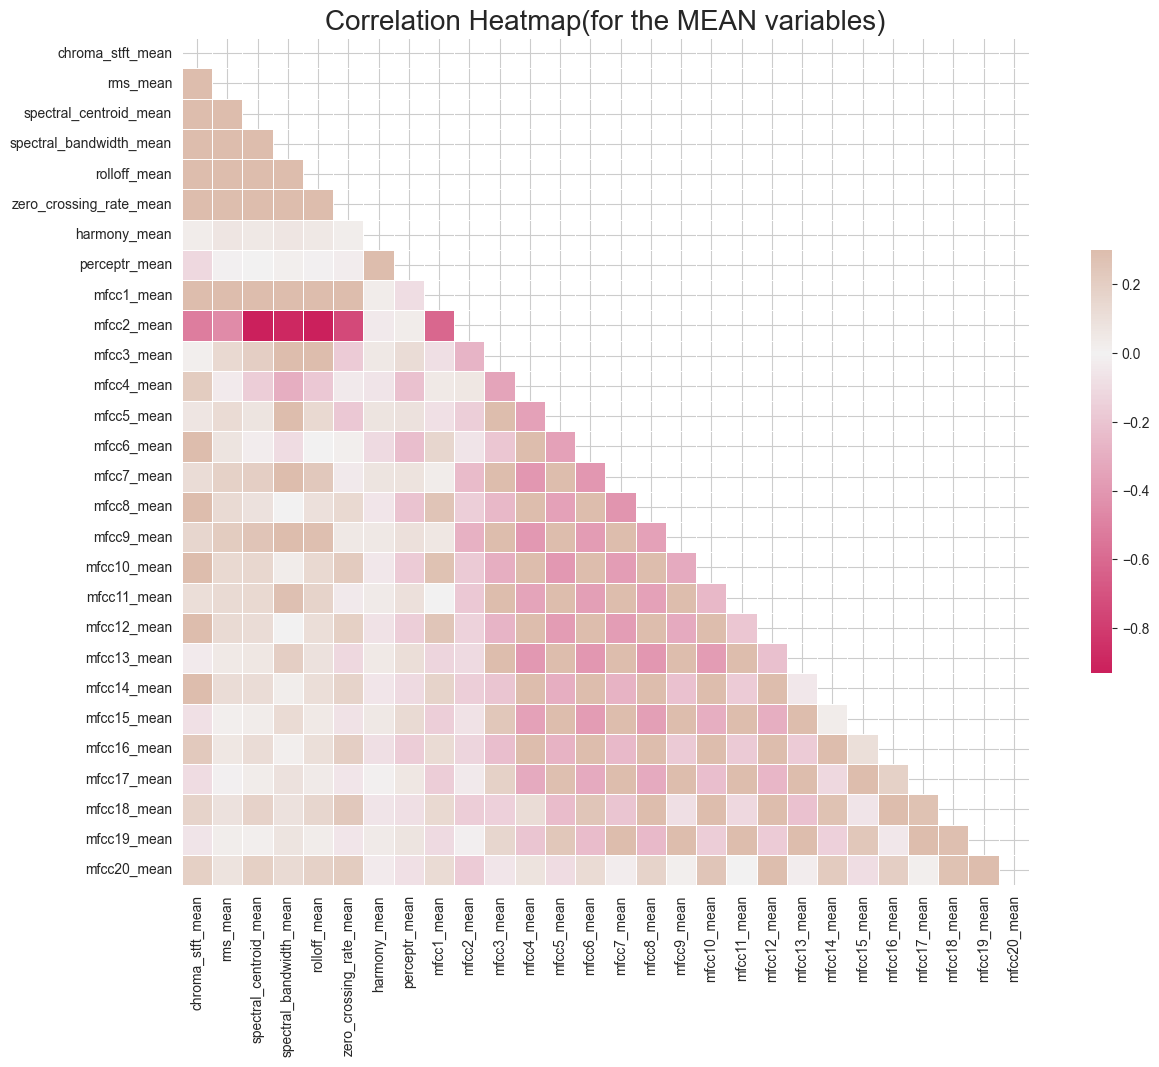

In [12]:
spike_cols = [ col for col in df.columns if 'mean' in col]
corr = df[spike_cols].corr()

## masking the uper triangle
mask = np.triu(np.ones_like(corr))

## visualising it through heatmap
f, ax = plt.subplots(figsize=(16,11))
cmap = sns.diverging_palette(0, 25, as_cmap=True, s = 90, l=45, n=5)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation Heatmap(for the MEAN variables)', fontsize = 20)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)

## Boxplot for genres

Text(0, 0.5, 'BPM')

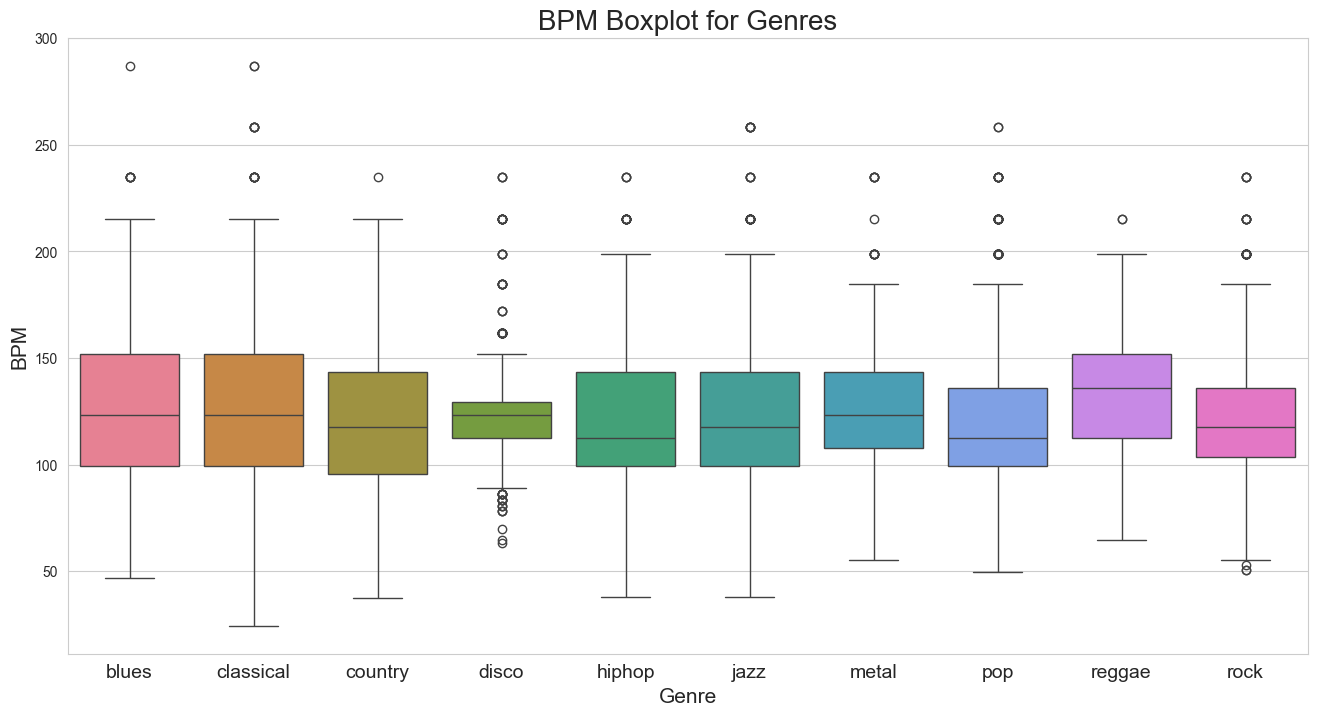

In [13]:
x = df[["label", "tempo"]]

fig, ax = plt.subplots(figsize=(16,8))
sns.boxplot(x="label", y="tempo", data = x, palette = "husl")

plt.title('BPM Boxplot for Genres', fontsize = 20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10)
plt.xlabel("Genre", fontsize = 15)
plt.ylabel("BPM", fontsize = 15)

          

## PCA for dimentionality reduction

Shape of PCA-transformed data: (9990, 2)


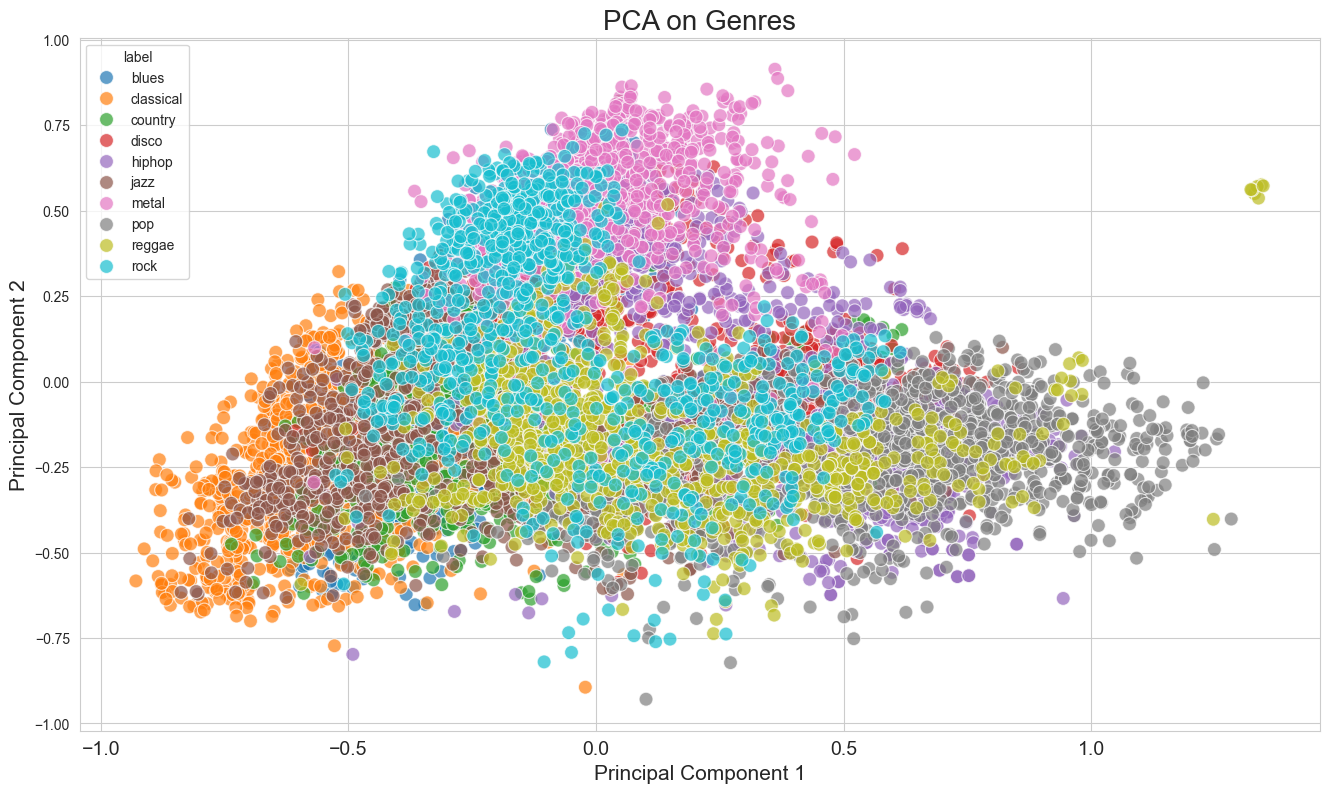

In [14]:
data = df.iloc[0:, 1:]
y= data['label']
x = data.loc[:, data.columns != 'label']

## Normalize using min-max scaler
cols = x.columns
min_max_scaler = skp.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(x)
x = pd.DataFrame(np_scaled, columns = cols)

## Applying PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2'])
print("Shape of PCA-transformed data:", principalComponents.shape)

finalDf = pd.concat([principalDf, y], axis = 1)

plt.figure(figsize = (16, 9))
sns.scatterplot(x = "pc1", y = "pc2", data = finalDf, hue = "label", alpha = 0.7, s = 100);

plt.title('PCA on Genres', fontsize = 20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel("Principal Component 1", fontsize = 15)
plt.ylabel("Principal Component 2", fontsize = 15)
plt.savefig("PCA_Scattert.png")

## Treating the missing values

In [15]:
print("Columns with NA values are",list(df.columns[df.isnull().any()]))

Columns with NA values are []


## Encoding of Genre Labels

In [16]:
label_index = dict()
index_label = dict()
for i, x in enumerate(df.label.unique()):
    label_index[x] = i
    index_label[i] = x
print(label_index)
print(index_label)

## updating labels in df
df.label = [label_index[l] for l in df.label]

{'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}
{0: 'blues', 1: 'classical', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}


## Splitting data into training, testing and development/validation set

In [17]:
df_shuffle = df.sample(frac=1, random_state=seed).reset_index(drop=True)

# remove irrelevant columns
df_shuffle.drop(['filename', 'length'], axis=1, inplace=True)
df_y = df_shuffle.pop('label')
df_X = df_shuffle

# split into train dev and test
X_train, df_test_valid_X, y_train, df_test_valid_y = skms.train_test_split(df_X, df_y, train_size=0.7, random_state=seed, stratify=df_y)
X_dev, X_test, y_dev, y_test = skms.train_test_split(df_test_valid_X, df_test_valid_y, train_size=0.66, random_state=seed, stratify=df_test_valid_y)

print(f"Train set has {X_train.shape[0]} records out of {len(df_shuffle)} which is {round(X_train.shape[0]/len(df_shuffle)*100)}%")
print(f"Dev set has {X_dev.shape[0]} records out of {len(df_shuffle)} which is {round(X_dev.shape[0]/len(df_shuffle)*100)}%")
print(f"Test set has {X_test.shape[0]} records out of {len(df_shuffle)} which is {round(X_test.shape[0]/len(df_shuffle)*100)}%")

Train set has 6993 records out of 9990 which is 70%
Dev set has 1978 records out of 9990 which is 20%
Test set has 1019 records out of 9990 which is 10%


## Scaling 

In [18]:
scaler = skp.StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_dev = pd.DataFrame(scaler.transform(X_dev), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

## Model Building


<h1 style="font-size:1rem; color:blue;"> Model 1 -> 4 layers </h1>

In [19]:
import tensorflow as tf
print("TF version:-", tf.__version__)
import keras as k
tf.random.set_seed(seed)

ACCURACY_THRESHOLD = 0.94

# To stop the training if val_accuracy exceeds the threshold
class myCallback(k.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy') > ACCURACY_THRESHOLD):
            print("\n\nStopping training as we have reached %2.2f%% accuracy!" %(ACCURACY_THRESHOLD*100))   
            self.model.stop_training = True

# Training the model using training and dev data
def trainModel(model, epochs, optimizer):
    batch_size = 128
    callback = myCallback()
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy']
    )
    return model.fit(X_train, y_train, validation_data=(X_dev, y_dev), epochs=epochs, 
                     batch_size=batch_size, callbacks=[callback])

def plotHistory(history):
    print("Max. Validation Accuracy",max(history.history["val_accuracy"]))
    pd.DataFrame(history.history).plot(figsize=(12,6))
    plt.show()

## Defining my model
model_1 = k.models.Sequential([
    k.layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    k.layers.Dense(128, activation='relu'),
    k.layers.Dense(64, activation='relu'),
    k.layers.Dense(10, activation='softmax'),
])
print(model_1.summary())
model_1_history = trainModel(model=model_1, epochs=70, optimizer='adam')


TF version:- 2.18.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │          14,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 56,650 (221.29 KB)

 Trainable params: 56,650 (221.29 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/70
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3796 - loss: 1.8010 - val_accuracy: 0.6355 - val_loss: 1.0588
Epoch 2/70
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6721 - loss: 0.9583 - val_accuracy: 0.7184 - val_loss: 0.8152
Epoch 3/70
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7581 - loss: 0.7369 - val_accuracy: 0.7604 - val_loss: 0.7079
Epoch 4/70
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8002 - loss: 0.6115 - val_accuracy: 0.7861 - val_loss: 0.6362
Epoch 5/70
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8308 - loss: 0.5191 - val_accuracy: 0.8023 - val_loss: 0.5819
Epoch 6/70
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8558 - loss: 0.4410 - val_accuracy: 0.8145 - val_loss: 0.5428
Epoch 7/70
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8819 - loss: 0.3740 - val_accuracy: 0.8367 - val_loss: 0.5108
Epoch 8/70
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9023 - loss: 0.3167 - val_accuracy: 0.8423 - val_

Max. Validation Accuracy 0.895348846912384


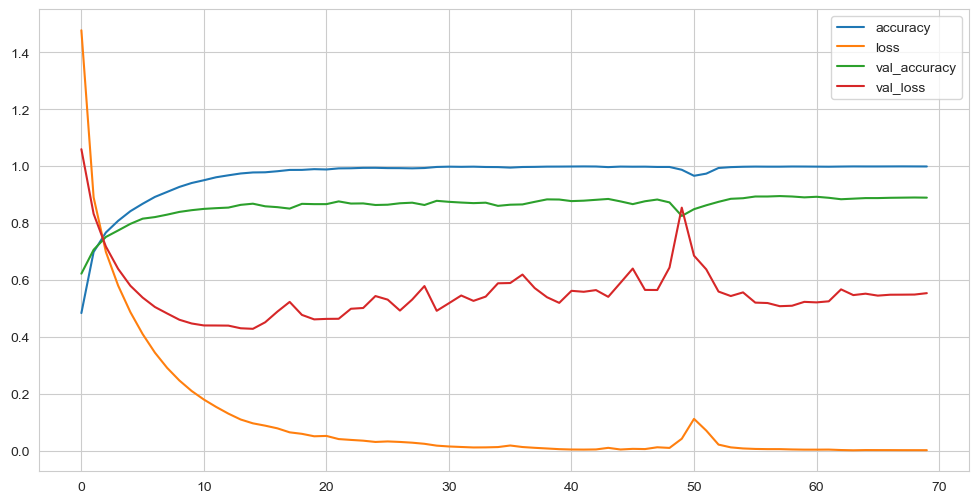

In [186]:
plotHistory(model_1_history)


<h1 style="font-size:1rem; color:blue;"> Model 2 -> 5 layers </h1>

In [21]:
model_2 = k.models.Sequential([
    k.layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    k.layers.Dropout(0.2),
    
    k.layers.Dense(256, activation='relu'),
    k.layers.Dropout(0.2),

    k.layers.Dense(128, activation='relu'),
    k.layers.Dropout(0.2),

    k.layers.Dense(64, activation='relu'),
    k.layers.Dropout(0.2),

    k.layers.Dense(10, activation='softmax'),
])
print(model_2.summary())
model_2_history = trainModel(model=model_2, epochs=100, optimizer='adam')

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                      │ (None, 512)                 │          29,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 202,826 (792.29 KB)

 Trainable params: 202,826 (792.29 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3150 - loss: 1.9154 - val_accuracy: 0.6077 - val_loss: 1.1094
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5980 - loss: 1.1598 - val_accuracy: 0.7002 - val_loss: 0.8549
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6716 - loss: 0.9597 - val_accuracy: 0.7427 - val_loss: 0.7411
Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7233 - loss: 0.8054 - val_accuracy: 0.7781 - val_loss: 0.6554
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7563 - loss: 0.7138 - val_accuracy: 0.8028 - val_loss: 0.5890
Epoch 6/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7885 - loss: 0.6365 - val_accuracy: 0.8165 - val_loss: 0.5613
Epoch 7/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8021 - loss: 0.5679 - val_accuracy: 0.8291 - val_loss: 0.5165
Epoch 8/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8304 - loss: 0.5093 - val_accuracy: 0.839

Max. Validation Accuracy 0.9282103180885315


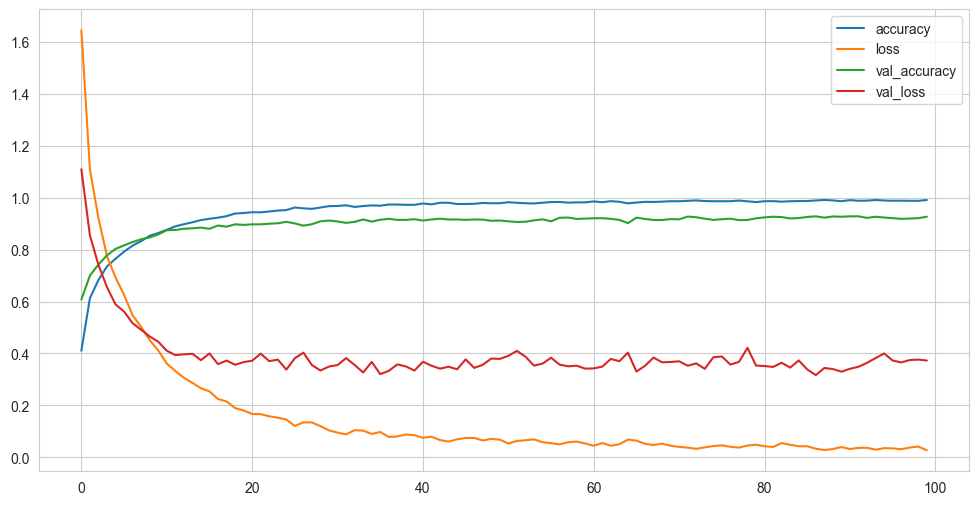

In [22]:
plotHistory(model_2_history)


<h1 style="font-size:1rem; color:blue;"> Model 3 -> 5 layers (sgd optimiser) </h1>

In [23]:
model_3 = k.models.Sequential([
    k.layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    k.layers.Dropout(0.2),
    
    k.layers.Dense(256, activation='relu'),
    k.layers.Dropout(0.2),

    k.layers.Dense(128, activation='relu'),
    k.layers.Dropout(0.2),

    k.layers.Dense(64, activation='relu'),
    k.layers.Dropout(0.2),

    k.layers.Dense(10, activation='softmax'),
])
print(model_3.summary())
model_3_history = trainModel(model=model_3, epochs=700, optimizer='sgd')

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                      │ (None, 512)                 │          29,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 202,826 (792.29 KB)

 Trainable params: 202,826 (792.29 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/700
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.1258 - loss: 2.3142 - val_accuracy: 0.3084 - val_loss: 2.1864
Epoch 2/700
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2103 - loss: 2.2046 - val_accuracy: 0.3670 - val_loss: 2.0562
Epoch 3/700
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2876 - loss: 2.0756 - val_accuracy: 0.3595 - val_loss: 1.9159
Epoch 4/700
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3148 - loss: 1.9625 - val_accuracy: 0.3675 - val_loss: 1.7969
Epoch 5/700
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3357 - loss: 1.8617 - val_accuracy: 0.3888 - val_loss: 1.7017
Epoch 6/700
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3729 - loss: 1.7739 - val_accuracy: 0.4166 - val_loss: 1.6235
Epoch 7/700
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3809 - loss: 1.7131 - val_accuracy: 0.4414 - val_loss: 1.5558
Epoch 8/700
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3994 - loss: 1.6604 - val_accuracy: 0.460

Max. Validation Accuracy 0.9226491451263428


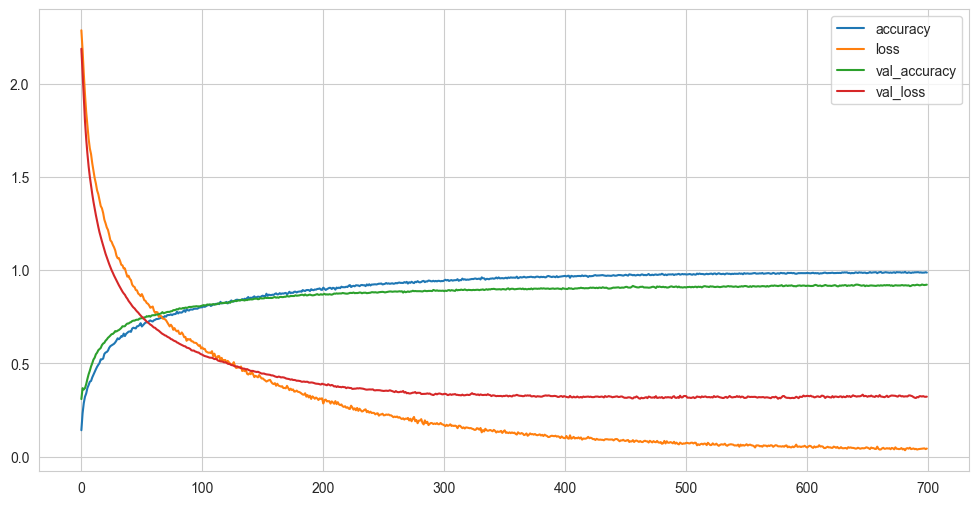

In [24]:
plotHistory(model_3_history)


<h1 style="font-size:1rem; color:blue;"> Model 4 -> 6 layers </h1>

In [25]:
model_4 = k.models.Sequential([
    k.layers.Dense(1024, activation='relu', input_shape=(X_train.shape[1],)),
    k.layers.Dropout(0.3),
    
    k.layers.Dense(512, activation='relu'),
    k.layers.Dropout(0.3),

    k.layers.Dense(256, activation='relu'),
    k.layers.Dropout(0.3),

    k.layers.Dense(128, activation='relu'),
    k.layers.Dropout(0.3),

    k.layers.Dense(64, activation='relu'),
    k.layers.Dropout(0.3),

    k.layers.Dense(10, activation='softmax'),
])
print(model_4.summary())
model_4_history = trainModel(model=model_4, epochs=500, optimizer='rmsprop')
Model: "sequential_3"

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_14 (Dense)                     │ (None, 1024)                │          59,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 757,322 (2.89 MB)

 Trainable params: 757,322 (2.89 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/500
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.2904 - loss: 1.9483 - val_accuracy: 0.5571 - val_loss: 1.2208
Epoch 2/500
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5039 - loss: 1.3651 - val_accuracy: 0.6289 - val_loss: 1.0428
Epoch 3/500
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6229 - loss: 1.1232 - val_accuracy: 0.7149 - val_loss: 0.8360
Epoch 4/500
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6739 - loss: 0.9654 - val_accuracy: 0.7518 - val_loss: 0.7272
Epoch 5/500
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7326 - loss: 0.8316 - val_accuracy: 0.7528 - val_loss: 0.7233
Epoch 6/500
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7499 - loss: 0.7687 - val_accuracy: 0.7715 - val_loss: 0.6890
Epoch 7/500
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7709 - loss: 0.6896 - val_accuracy: 0.8205 - val_loss: 0.5645
Epoch 8/500
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8033 - loss: 0.6139 - val_accurac

Max. Validation Accuracy 0.9408493638038635


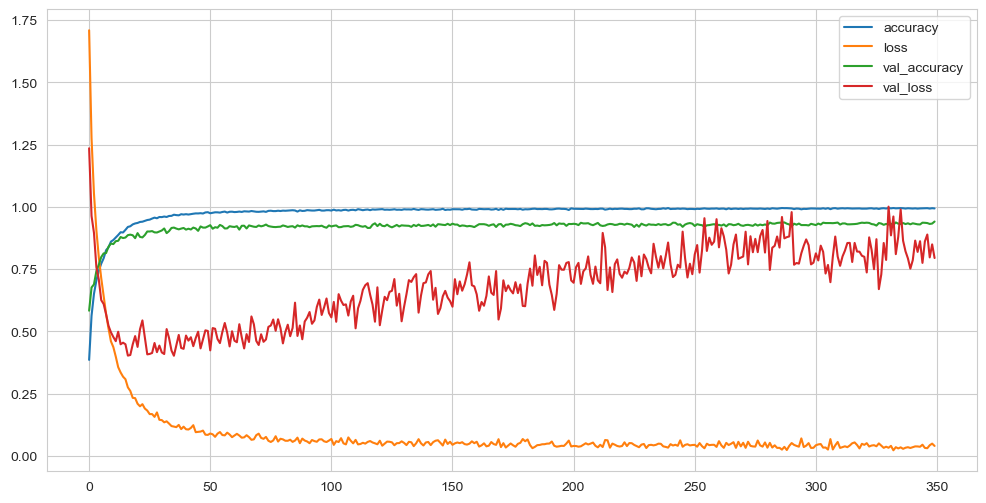

In [178]:
plotHistory(model_4_history)

## Model Evaluation Parameters for each model

## Model 1

In [59]:
test_loss, test_acc  = model_1.evaluate(X_test, y_test, batch_size=128)
print("The test Loss is :",test_loss)
print("\nThe Best test Accuracy is :",test_acc*100)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8927 - loss: 0.5404
The test Loss is : 0.6074508428573608

The Best test Accuracy is : 88.22374939918518


In [60]:
#model 1
# calculating precision , recall , f1 score

from sklearn.metrics import precision_score, recall_score, classification_report
from sklearn.metrics import f1_score
# Get model predictions
y_pred = model_1.predict(X_test, batch_size=128)
y_pred_classes = y_pred.argmax(axis=1)  

# Calculate precision and recall
precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# F1 Score
f1 = f1_score(y_test, y_pred_classes,average='weighted')
print(f"F1 Score: {f1:.2f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Precision: 0.8825
Recall: 0.8822
F1 Score: 0.88


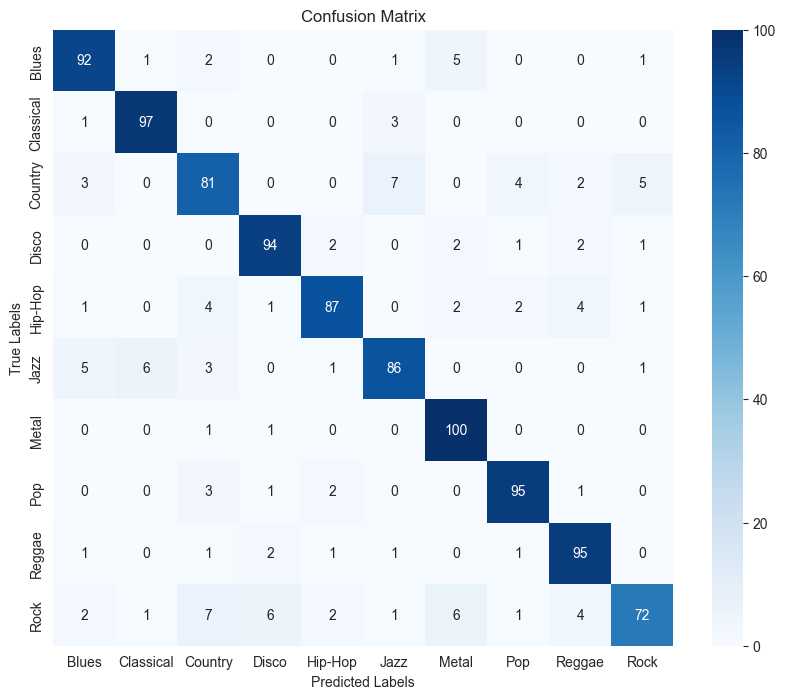

In [61]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
genre_labels = ['Blues', 'Classical', 'Country', 'Disco', 'Hip-Hop', 
                'Jazz', 'Metal', 'Pop', 'Reggae', 'Rock']


# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=genre_labels, yticklabels=genre_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


## Model 2

In [62]:
test_loss, test_acc  = model_2.evaluate(X_test, y_test, batch_size=128)
print("The test Loss is :",test_loss)
print("\nThe Best test Accuracy is :",test_acc*100)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9278 - loss: 0.3568
The test Loss is : 0.3693195581436157

The Best test Accuracy is : 92.63984560966492


In [63]:
#model 2
# calculating precision , recall , f1 score

from sklearn.metrics import precision_score, recall_score, classification_report
from sklearn.metrics import f1_score
# Get model predictions
y_pred = model_2.predict(X_test, batch_size=128)
y_pred_classes = y_pred.argmax(axis=1)  

# Calculate precision and recall
precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# F1 Score
f1 = f1_score(y_test, y_pred_classes,average='weighted')
print(f"F1 Score: {f1:.2f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Precision: 0.9266
Recall: 0.9264
F1 Score: 0.93


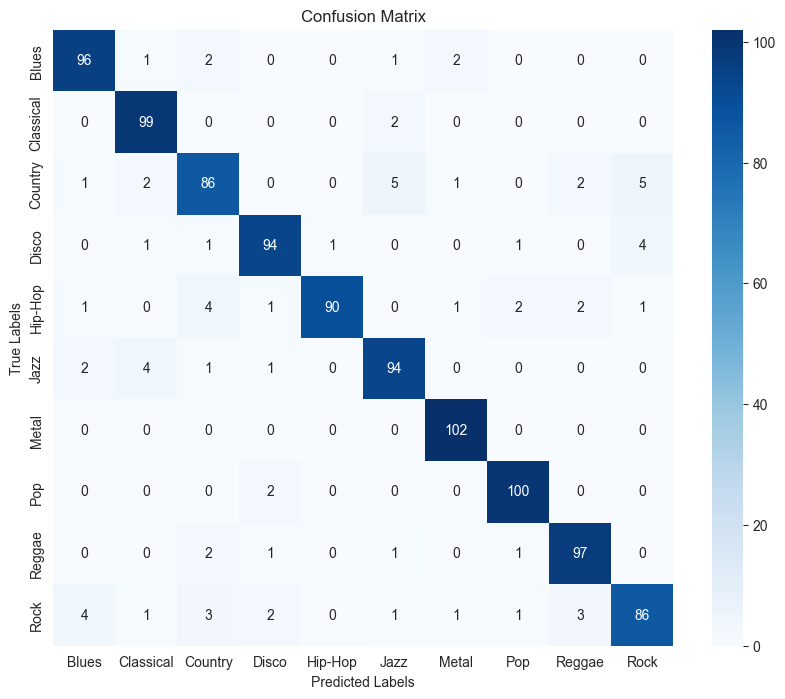

In [64]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
genre_labels = ['Blues', 'Classical', 'Country', 'Disco', 'Hip-Hop', 
                'Jazz', 'Metal', 'Pop', 'Reggae', 'Rock']


# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=genre_labels, yticklabels=genre_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


## Model 3

In [65]:
test_loss, test_acc  = model_3.evaluate(X_test, y_test, batch_size=128)
print("The test Loss is :",test_loss)
print("\nThe Best test Accuracy is :",test_acc*100)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9251 - loss: 0.3230 
The test Loss is : 0.3497759997844696

The Best test Accuracy is : 91.75662398338318


In [66]:
#model 3
# calculating precision , recall , f1 score

from sklearn.metrics import precision_score, recall_score, classification_report
from sklearn.metrics import f1_score
# Get model predictions
y_pred = model_3.predict(X_test, batch_size=128)
y_pred_classes = y_pred.argmax(axis=1)  

# Calculate precision and recall
precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# F1 Score
f1 = f1_score(y_test, y_pred_classes,average='weighted')
print(f"F1 Score: {f1:.2f}")


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Precision: 0.9180
Recall: 0.9176
F1 Score: 0.92


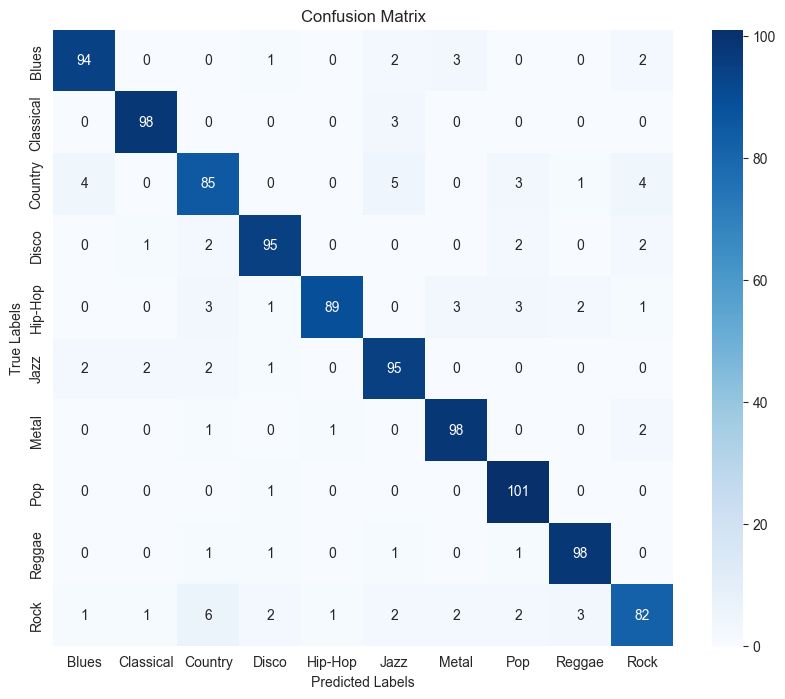

In [67]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
genre_labels = ['Blues', 'Classical', 'Country', 'Disco', 'Hip-Hop', 
                'Jazz', 'Metal', 'Pop', 'Reggae', 'Rock']


# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=genre_labels, yticklabels=genre_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


## Model 4

In [68]:
test_loss, test_acc  = model_4.evaluate(X_test, y_test, batch_size=128)
print("The test Loss is :",test_loss)
print("\nThe Best test Accuracy is :",test_acc*100)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9434 - loss: 1.1074 
The test Loss is : 1.0783435106277466

The Best test Accuracy is : 93.62119436264038


In [69]:
#model 4
# calculating precision , recall , f1 score

from sklearn.metrics import precision_score, recall_score, classification_report
from sklearn.metrics import f1_score
# Get model predictions
y_pred = model_4.predict(X_test, batch_size=128)
y_pred_classes = y_pred.argmax(axis=1)  

# Calculate precision and recall
precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# F1 Score
f1 = f1_score(y_test, y_pred_classes,average='weighted')
print(f"F1 Score: {f1:.2f}")




8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Precision: 0.9368
Recall: 0.9362
F1 Score: 0.94


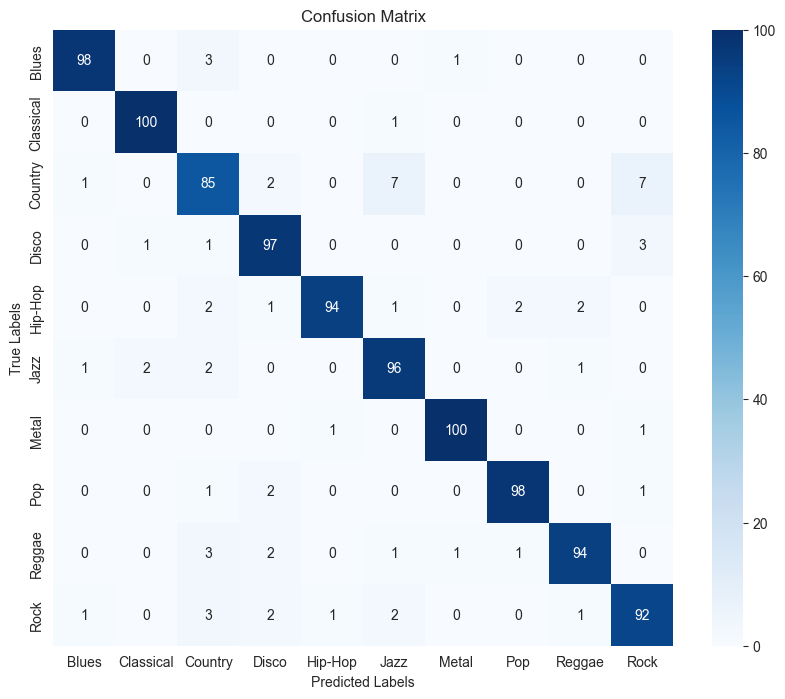

In [70]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
genre_labels = ['Blues', 'Classical', 'Country', 'Disco', 'Hip-Hop', 
                'Jazz', 'Metal', 'Pop', 'Reggae', 'Rock']


# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=genre_labels, yticklabels=genre_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


## Thankyou